<h3 style="text-align: center;"><b>Deep Learning School FPMI MIPT</b></h3>

<h3 style="text-align: center;"><b>The final project CycleGAN Network

**Sources used**:
- https://github.com/jiechen2358/FaceAging-by-cycleGAN/tree/master/models
- https://www.kaggle.com/code/nachiket273/cyclegan-pytorch/notebook
- https://www.kaggle.com/code/balraj98/cyclegan-translating-paintings-photos-pytorch
- https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix


The proposed network architecture is shown schematically below.

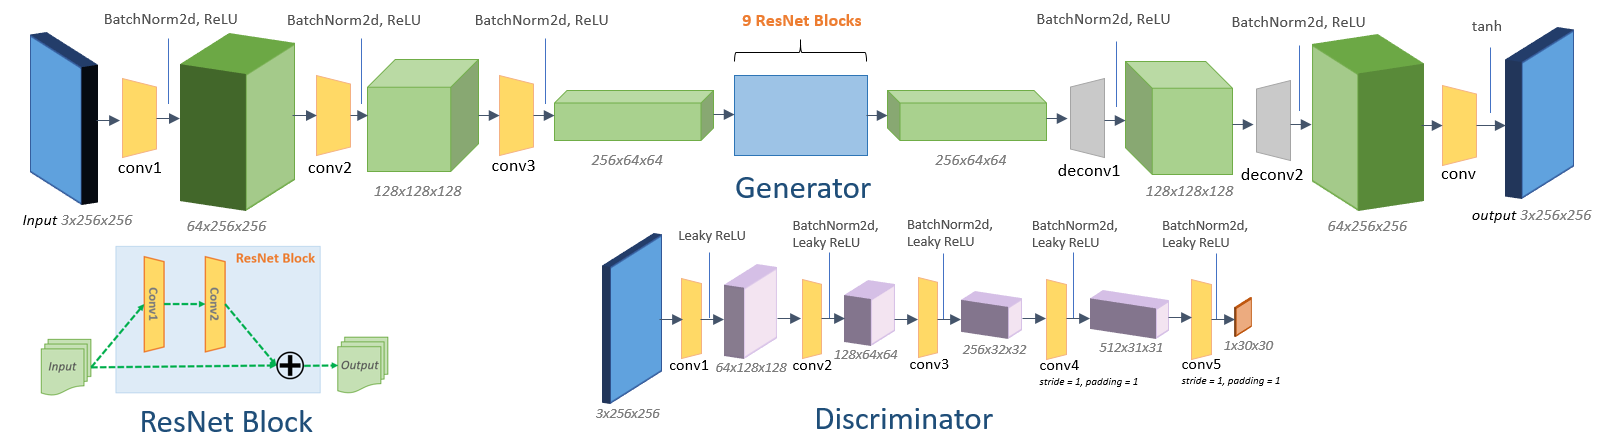

In [1]:
import os
from pathlib import Path
import time
import gc
import random
from tqdm.notebook import tqdm
import pandas as pd
import numpy as np
import pickle
from skimage import io
import itertools
from PIL import Image
from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder

import cv2
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets import ImageFolder
import torch.nn as nn
import torch.nn.functional as F
from torchvision.utils import save_image, make_grid
from torchvision import transforms

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)

sns.set(style='darkgrid', font_scale=1.2)

In [2]:
def set_seed(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

In [3]:
set_seed(42)

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

For the demo run, small values of RESCALE_SIZE and n_epochs were chosen. The main network was trained on 256x256 images for 100 epochs

In [5]:
RESCALE_SIZE = 64
n_epochs = 100
batch_size = 1

In training datasets, a different number of pictures, so that there are no problems with loading files into the dataloader, we will select a thousand from each set and we will train on them

In [6]:
train_monet = Path('data/monet2photo/trainA')
train_photo = Path('data/monet2photo/trainB')
test_monet = Path('data/monet2photo/testA')
test_photo = Path('data/monet2photo/testB')

train_A_files = sorted(list(train_monet.rglob('*.jpg')))[:1000]
train_B_files = sorted(list(train_photo.rglob('*.jpg')))[:1000]
test_A_files = sorted(list(test_monet.rglob('*.jpg')))
test_B_files = sorted(list(test_photo.rglob('*.jpg')))

print(len(train_A_files))
print(len(train_B_files))
print(len(test_A_files))
print(len(test_B_files))

1000
1000
121
751


In [7]:
class Images_Dataset(Dataset):
    def __init__(self, files_A, files_B, rescale_size = RESCALE_SIZE):
        super().__init__()
        self.files_A = sorted(files_A)
        self.files_B = sorted(files_B)
        self.rescale_size = rescale_size

    def __getitem__(self, index):
        transform = transforms.Compose([
            transforms.Resize(self.rescale_size),                            
            transforms.ToTensor(),
            transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]) 
        ])
        A_i = Image.open(self.files_A[index % len(self.files_A)]).convert('RGB')
        A_i = transform(A_i)
        B_i = Image.open(self.files_B[index % len(self.files_B)]).convert('RGB')
        B_i = transform(B_i)
        return {"A": A_i, "B": B_i}

    def __len__(self):
        return max(len(self.files_A), len(self.files_B))



def imshow(inp, title=None, plt_ax=plt, default=False):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.5, 0.5, 0.5]) 
    std = np.array([0.5, 0.5, 0.5])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

We load the training dataset and check several images from each set

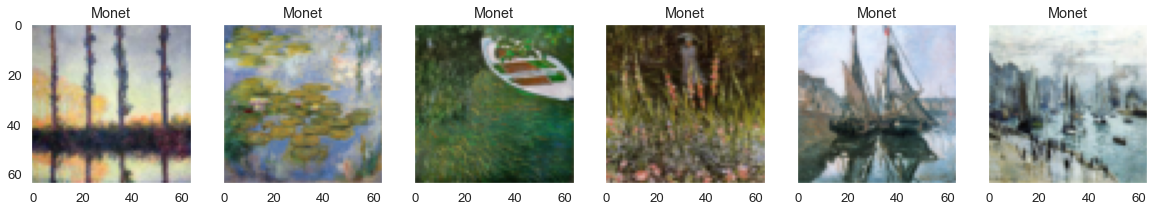

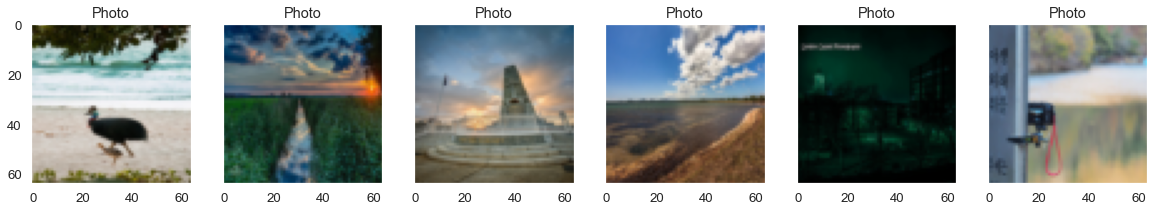

In [8]:
train_dataset = Images_Dataset(train_A_files,train_B_files)

fig, ax = plt.subplots(nrows=1, ncols=6,figsize=(20, 10), sharey=True, sharex=True)

for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    random_pic = train_dataset[random_characters]
    imshow(random_pic['A'].data.cpu(),'Monet', plt_ax=fig_x)

fig, ax = plt.subplots(nrows=1, ncols=6,figsize=(20, 5), sharey=True, sharex=True)

for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    random_pic = train_dataset[random_characters]
    imshow(random_pic['B'].data.cpu(), 'Photo',plt_ax=fig_x)

Create a generator and discriminator

In [9]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Sequential(*[
                                        nn.ReflectionPad2d(3),
                                        nn.Conv2d(3, 64, kernel_size=7),
                                        nn.BatchNorm2d(64),
                                        nn.ReLU(True)]
                                        )
        self.conv2 = nn.Sequential(*[ 
                                        nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
                                        nn.BatchNorm2d(128),
                                        nn.ReLU(True)]
                                        ) 
        self.conv3 = nn.Sequential(*[ 
                                        nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),
                                        nn.BatchNorm2d(256),
                                        nn.ReLU(True)]
                                        ) 
        self.ResNet_block = nn.Sequential(*[
                                        nn.ReflectionPad2d(1),
                                        nn.Conv2d(256, 256, kernel_size=3),
                                        nn.BatchNorm2d(256),
                                        nn.ReLU(True),
                                        nn.ReflectionPad2d(1),
                                        nn.Conv2d(256, 256, kernel_size=3),
                                        nn.BatchNorm2d(256),
                                        nn.ReLU(True)]
                                        ) 

        self.deconv1 = nn.Sequential(*[
                                        nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1),
                                        nn.BatchNorm2d(128),
                                        nn.ReLU(True)]                             
                                    )
        self.deconv2 = nn.Sequential(*[
                                        nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
                                        nn.BatchNorm2d(64),
                                        nn.ReLU(True)]                             
                                    )
        self.deconv3 = nn.Sequential(
                                        *[
                                        nn.ReflectionPad2d(3),
                                        nn.Conv2d(64, 3, kernel_size = 7, stride=1)]
                                       )

    def forward(self, x, num_blocks=9):
        # encoder
        l1 = self.conv1(x)
        l2 = self.conv2(l1)
        l3 = self.conv3(l2)
        for i in range(num_blocks):
            if i == 0:
                l = l3
            else:
                l = rn
            rn = l + self.ResNet_block(self.ResNet_block(l))
        l4 = self.deconv1(rn)
        l5 = self.deconv2(l4)
        l6 = self.deconv3(l5)
        return torch.tanh(l6)

In [10]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Sequential(*[
                                    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1),
                                    nn.LeakyReLU(0.2, True)]
                                  )
        self.conv2 = nn.Sequential(*[
                                    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
                                    nn.BatchNorm2d(128),
                                    nn.LeakyReLU(0.2, True)]
                                  )
        self.conv3 = nn.Sequential(*[
                                    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
                                    nn.BatchNorm2d(256),
                                    nn.LeakyReLU(0.2, True)]
                                  )
        self.conv4 = nn.Sequential(*[
                                    nn.Conv2d(256, 512, kernel_size=4, padding=1),
                                    nn.BatchNorm2d(512),
                                    nn.LeakyReLU(0.2, True)]
                                  )
        self.conv5 = nn.Sequential(*[
                                    nn.Conv2d(512, 1, kernel_size=4, padding=1)]
                                  )
        
    def forward(self, x):
        x = self.conv5(self.conv4(self.conv3(self.conv2(self.conv1(x)))))
        x = F.avg_pool2d(x, x.size()[2:])
        x = torch.flatten(x, 1)
        return x

The block below is used to store the generated images

In [11]:
class FakeSamples:
    def __init__(self, max_size=50):
        self.max_size = max_size
        self.data = []

    def call(self, data):
        returned = []
        for el in data.data:
            el = torch.unsqueeze(el, 0)
            if len(self.data) < self.max_size:
                self.data.append(el)
                returned.append(el)
            else:
                if random.uniform(0, 1) > 0.5:
                    i = random.randint(0, self.max_size - 1)
                    returned.append(self.data[i].clone())
                    self.data[i] = el
                else:
                    returned.append(el)
        return torch.cat(returned)

Let's implement CycleGAN

In [12]:
class Cycle_GAN(nn.Module):
    def __init__(self, generator_A2B, generator_B2A, discriminator_A, discriminator_B):
        super(Cycle_GAN, self).__init__()
        self.generator_A2B = generator_A2B
        self.generator_B2A = generator_B2A
        self.discriminator_A = discriminator_A
        self.discriminator_B = discriminator_B
    
    def forward(self, batch_A, batch_B):
        gen_b = self.generator_A2B(batch_A)
        gen_a_from_gen_b = self.generator_B2A(gen_b)
        
        gen_a = self.generator_B2A(batch_B)
        gen_b_from_gen_a = self.generator_A2B(gen_a)
        
        true_b = self.discriminator_B(batch_B)
        fake_b = self.discriminator_B(gen_b)
        
        true_a = self.discriminator_A(batch_A)
        fake_a = self.discriminator_A(gen_a)
        
        ident_b = self.generator_A2B(batch_B)
        ident_a = self.generator_B2A(batch_A)
        
        return gen_b, gen_a, gen_a_from_gen_b, gen_b_from_gen_a, true_a, fake_a, true_b, fake_b, ident_a, ident_b

We load networks on the video card, select loss-functions and optimizers

In [13]:
dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

Gen_A2B = Generator().to(device)
Gen_B2A = Generator().to(device)
Disc_A = Discriminator().to(device)
Disc_B = Discriminator().to(device)

lmbda = 10.
idt_coef = 0.5
gan_model = Cycle_GAN(Gen_A2B, Gen_B2A, Disc_A, Disc_B).to(device)

loss_GAN = torch.nn.MSELoss().to(device)
loss_cycle = torch.nn.L1Loss().to(device)
loss_identity = torch.nn.L1Loss().to(device)

optim_G   = torch.optim.Adam(itertools.chain(Gen_A2B.parameters(), Gen_B2A.parameters()), lr=0.0002, betas=(0.5, 0.999))
optim_D_A = torch.optim.Adam(Disc_A.parameters(),  lr=0.0002, betas=(0.5, 0.999))
optim_D_B = torch.optim.Adam(Disc_B.parameters(), lr=0.0002, betas=(0.5, 0.999))

losses_G_ = 0
losses_D_A_ = 0
losses_D_B_ = 0
losses_G = []
losses_D_A = []
losses_D_B = []

losses_GAN      = []
losses_cycle    = []
losses_identity = []

fake_A_buffer = FakeSamples()
fake_B_buffer = FakeSamples()

In [14]:
torch.cuda.empty_cache()
gc.collect()

14606

Starting network training

In [15]:
log_template = " \nEpoch {ep:03d}  sum_loss_G: {sum_loss_G:0.4f} loss_D_A_full {loss_D_A_full:0.4f} loss_D_B_full {loss_D_B_full:0.4f}\
                 loss_identity_A {loss_identity_A:0.4f} loss_identity_B {loss_identity_B:0.4f}"


with tqdm(desc="epoch", total=n_epochs) as pbar_outer:
    for epoch in range(n_epochs):
        for i, batch in enumerate(dataloader):
            real_image_A = batch["A"].to(device)
            real_image_B = batch["B"].to(device)

            gan_model.train()
            
            real_label = torch.ones(batch_size, 1).to(device)
            fake_label = torch.zeros(batch_size, 1).to(device)

            #Generators
            optim_G.zero_grad()
            
            gen_b, gen_a, gen_a_from_gen_b, gen_b_from_gen_a, true_a, fake_a, true_b, fake_b, ident_a, ident_b = gan_model.forward(real_image_A, real_image_B)
            
            loss_identity_A = lmbda*idt_coef*loss_identity(ident_a, real_image_A)
            loss_identity_B = lmbda*idt_coef*loss_identity(ident_b, real_image_B)
            losses_identity.append((loss_identity_A.item() + loss_identity_B.item())/2.0)
            
            loss_GAN_A2B = loss_GAN(fake_b, real_label)
            loss_GAN_B2A = loss_GAN(fake_a, real_label)
            losses_GAN.append((loss_GAN_B2A.item() + loss_GAN_A2B.item())/2.0)
            
            loss_cycle_ABA = lmbda*loss_cycle(gen_a_from_gen_b, real_image_A)
            loss_cycle_BAB = lmbda*loss_cycle(gen_b_from_gen_a, real_image_B)
            losses_cycle.append((loss_cycle_BAB.item() + loss_cycle_ABA.item())/2.0)
            
            sum_loss_G = loss_identity_A + loss_identity_B + loss_GAN_A2B + loss_GAN_B2A + loss_cycle_ABA + loss_cycle_BAB
            losses_G.append(sum_loss_G.item())
            losses_G_+=sum_loss_G.item()
            
            sum_loss_G.backward()
            optim_G.step()
       
            # Discriminator A 
            optim_D_A.zero_grad()
            loss_D_A_real = loss_GAN(true_a, real_label)
            fake_A = fake_A_buffer.call(gen_a)
            loss_D_A_fake = loss_GAN(Disc_A(fake_A.detach()), fake_label)
            loss_D_A_full = (loss_D_A_real + loss_D_A_fake)/2.0
            
            losses_D_A.append(loss_D_A_full.item())
            losses_D_A_+=(loss_D_A_full.item())
            
            loss_D_A_full.backward()
            optim_D_A.step()

            # Discriminator B 
            optim_D_B.zero_grad()
            loss_D_B_real = loss_GAN(true_b, real_label)
            fake_B = fake_B_buffer.call(gen_b)
            loss_D_B_fake = loss_GAN(Disc_B(fake_B.detach()), fake_label)
            loss_D_B_full = (loss_D_B_real + loss_D_B_fake)/2.0
            
            losses_D_B.append(loss_D_B_full.item())
            losses_D_B_+=loss_D_B_full.item()
            
            loss_D_B_full.backward()
            optim_D_B.step()
    
        losses_G_ /= dataloader.__len__()
        losses_D_A_ /= dataloader.__len__()
        losses_D_B_ /= dataloader.__len__()
        
        losses_G.append(losses_G_)
        losses_D_A.append(losses_D_A_)
        losses_D_B.append(losses_D_B_)
    
        tqdm.write(log_template.format(ep=epoch+1,
                                       sum_loss_G=sum_loss_G,
                                       loss_D_A_full=loss_D_A_full,
                                       loss_D_B_full=loss_D_B_full,
                                       loss_identity_A=loss_identity_A,
                                       loss_identity_B=loss_identity_B))
        pbar_outer.update(1)

epoch:   0%|          | 0/10 [00:00<?, ?it/s]

 
Epoch 001  sum_loss_G: 10.1376 loss_D_A_full 0.0357 loss_D_B_full 0.1858                 loss_identity_A 1.7922 loss_identity_B 1.0912
 
Epoch 002  sum_loss_G: 10.9051 loss_D_A_full 0.0473 loss_D_B_full 0.0068                 loss_identity_A 1.2078 loss_identity_B 1.9072
 
Epoch 003  sum_loss_G: 14.2045 loss_D_A_full 0.5363 loss_D_B_full 0.0204                 loss_identity_A 2.8500 loss_identity_B 1.4952
 
Epoch 004  sum_loss_G: 6.3891 loss_D_A_full 0.2328 loss_D_B_full 0.1169                 loss_identity_A 0.9902 loss_identity_B 1.0108
 
Epoch 005  sum_loss_G: 6.8710 loss_D_A_full 0.0377 loss_D_B_full 0.1035                 loss_identity_A 1.1097 loss_identity_B 0.9101
 
Epoch 006  sum_loss_G: 5.7097 loss_D_A_full 0.1631 loss_D_B_full 0.0474                 loss_identity_A 0.5649 loss_identity_B 0.8714
 
Epoch 007  sum_loss_G: 6.4599 loss_D_A_full 0.2409 loss_D_B_full 0.2875                 loss_identity_A 0.8205 loss_identity_B 1.1091
 
Epoch 008  sum_loss_G: 6.2092 loss_D_A_full

Сохраняем параметры обученной сети

In [16]:
#torch.save(Gen_A2B.state_dict(), 'saved_models/Gen_A2B_256.pt')
#torch.save(Gen_B2A.state_dict(), 'saved_models/Gen_B2A_256.pt')
#torch.save(Disc_A.state_dict(), 'saved_models/Disc_A_256.pt')
#torch.save(Disc_B.state_dict(), 'saved_models/Disc_B_256.pt')

In [17]:
def show_results(results):
    for key in results:
        plt.figure(figsize=(18,10))
        plt.title(key, fontdict = {'fontsize': 24})
        plt.xlabel('Epochs', fontdict = {'fontsize': 20})
        plt.ylabel('loss', fontdict = {'fontsize': 20})
        plt.plot(results[key])
        plt.show

Below you can take a look at the losses of generators and discriminators

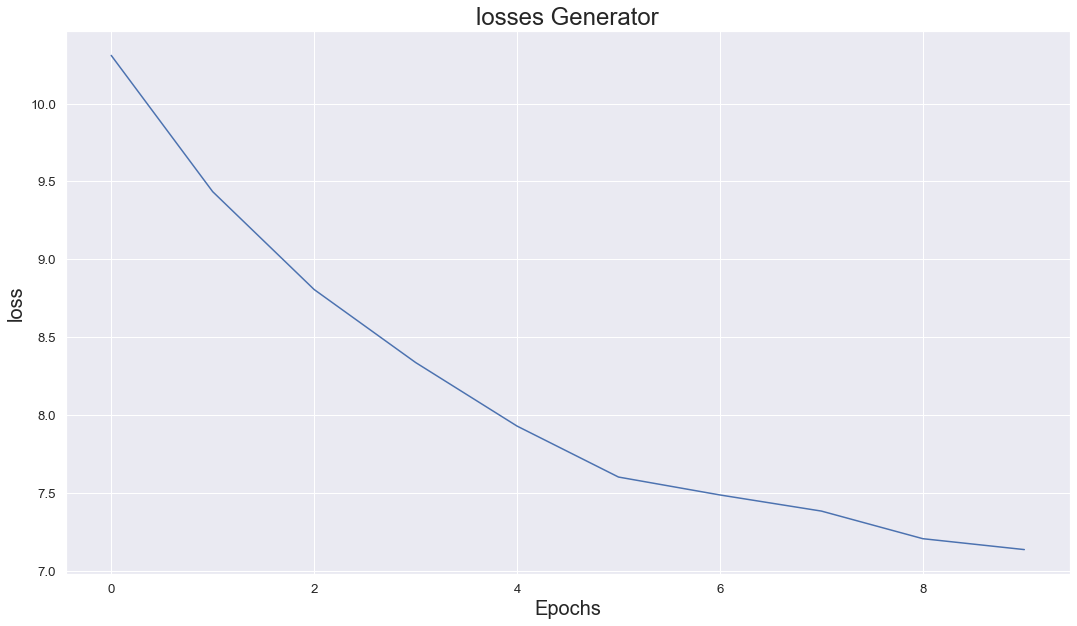

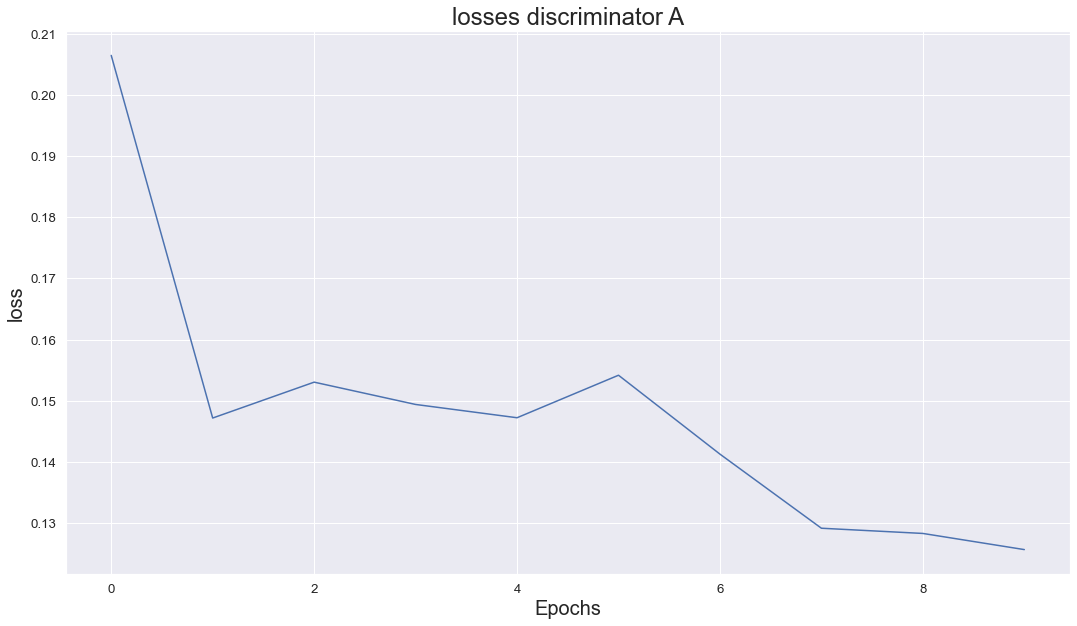

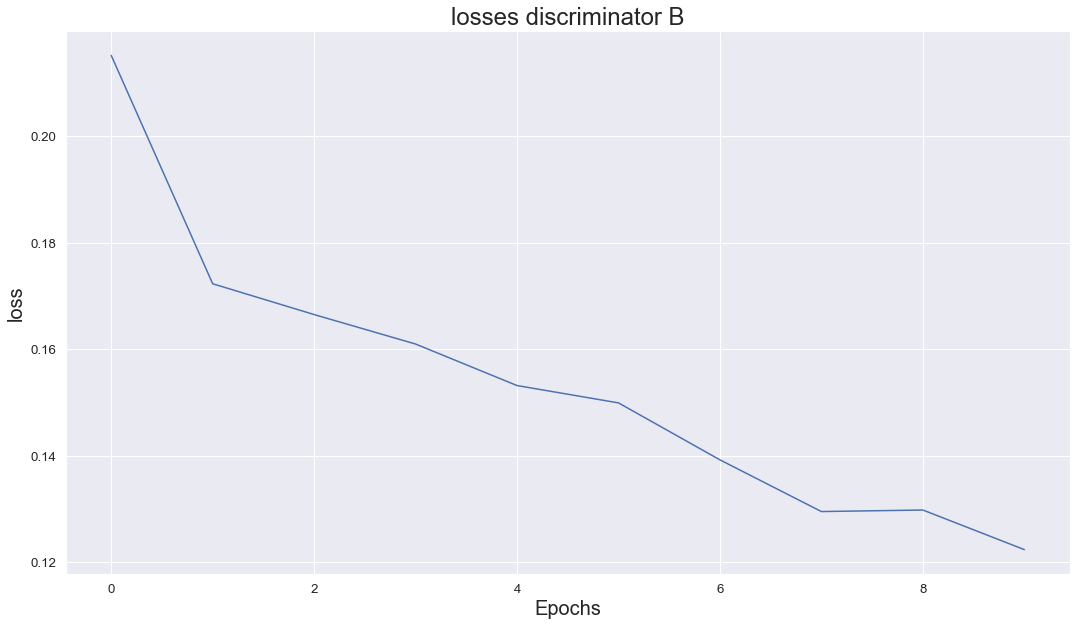

In [18]:
results = {'losses Generator':losses_G, 'losses discriminator A': losses_D_A,'losses discriminator B': losses_D_B}
show_results(results)

Loading a pretrained network for pictures 256x256

In [22]:
Gen_A2B.load_state_dict(torch.load('saved_models/Gen_A2B_256.pt', map_location=device))
Gen_B2A.load_state_dict(torch.load('saved_models/Gen_B2A_256.pt', map_location=device))

<All keys matched successfully>

Let's take a look at learning outcomes

In [23]:
test_dataset = Images_Dataset(test_A_files[60:70],test_B_files[60:70],256)

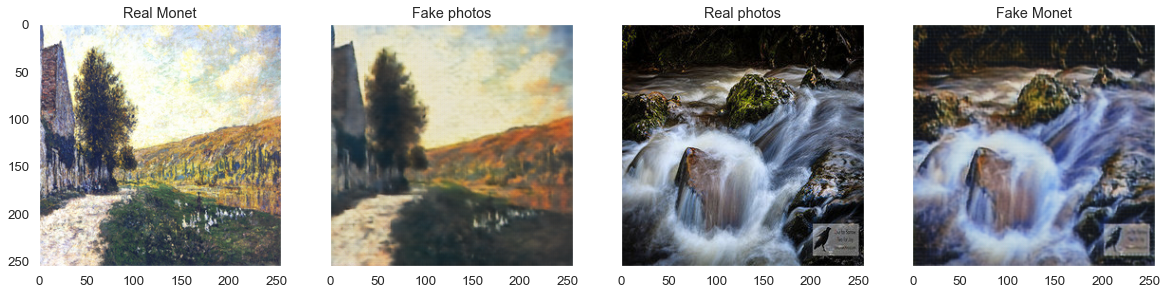

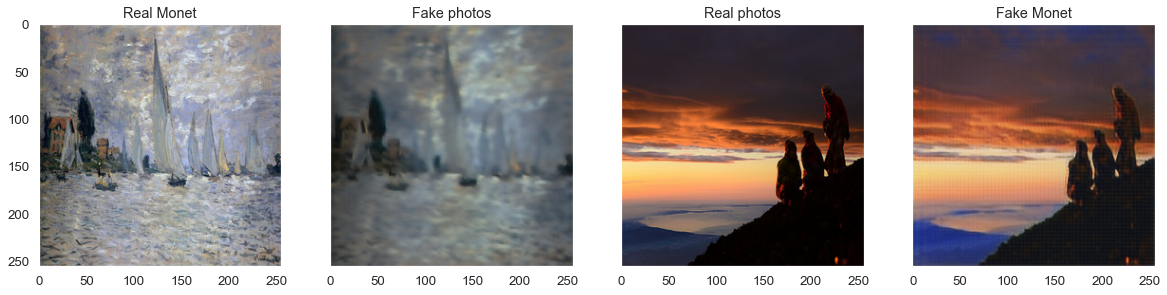

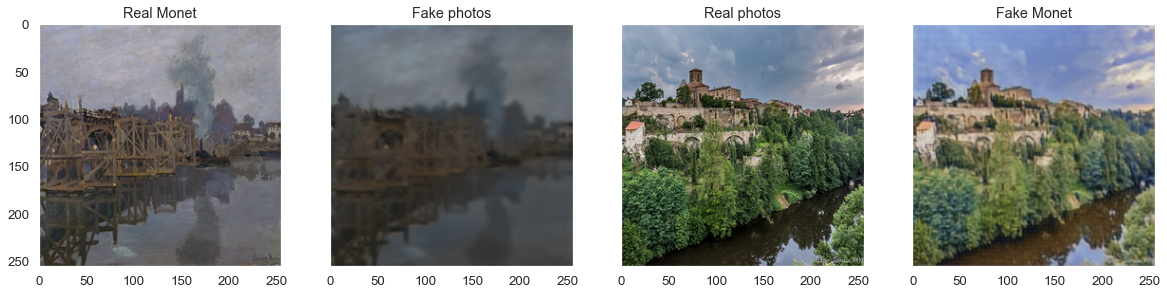

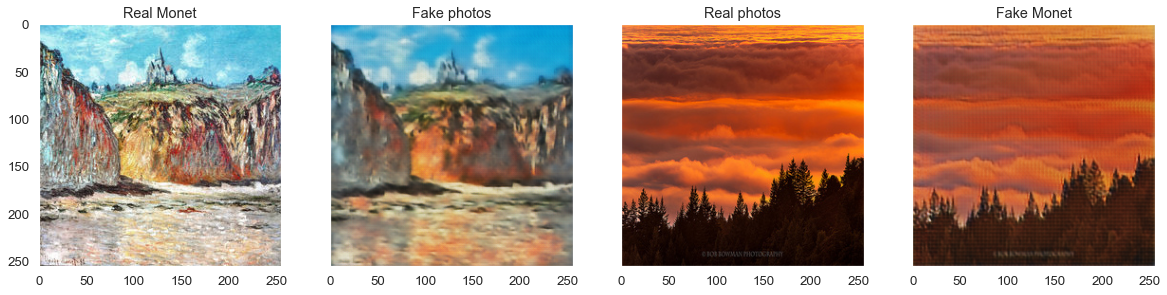

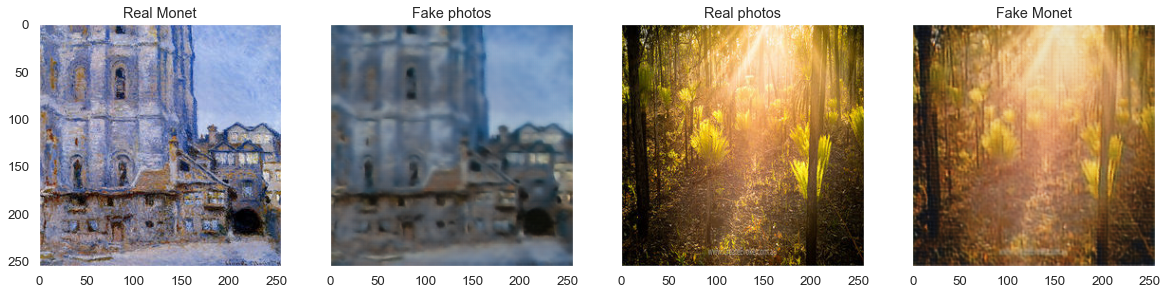

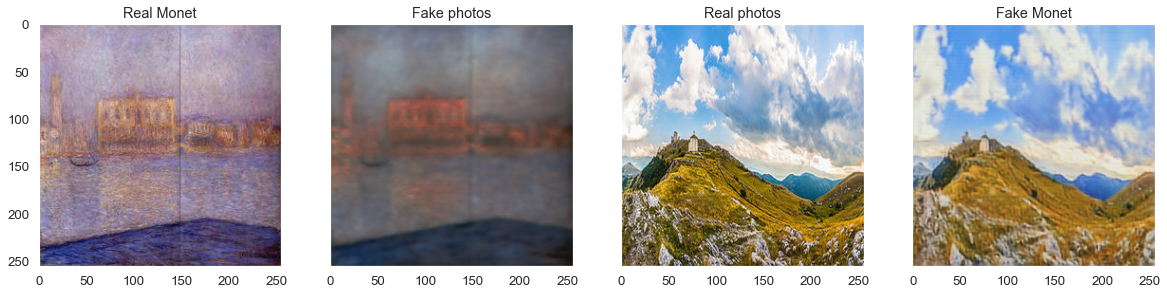

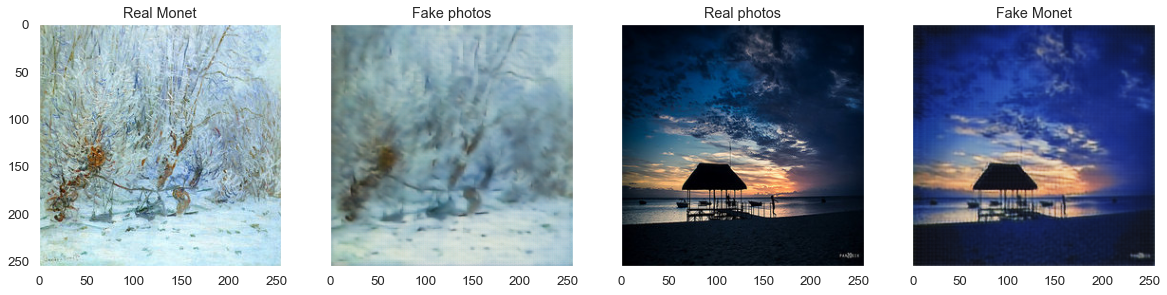

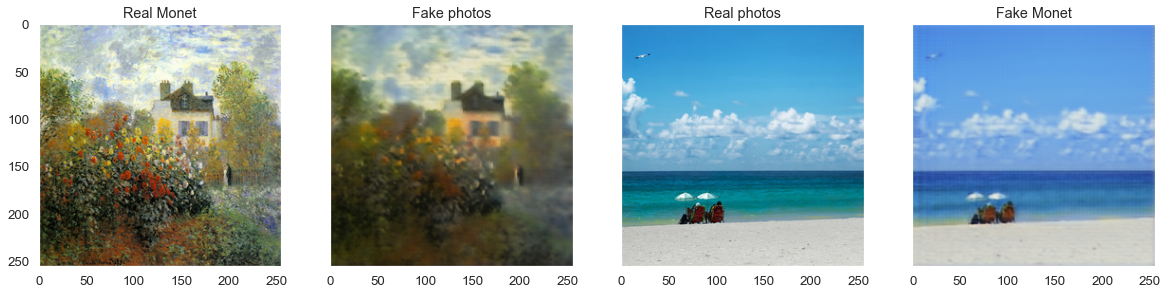

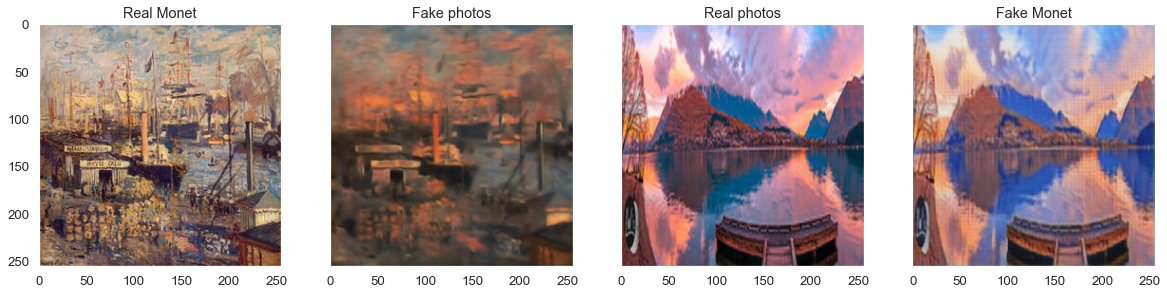

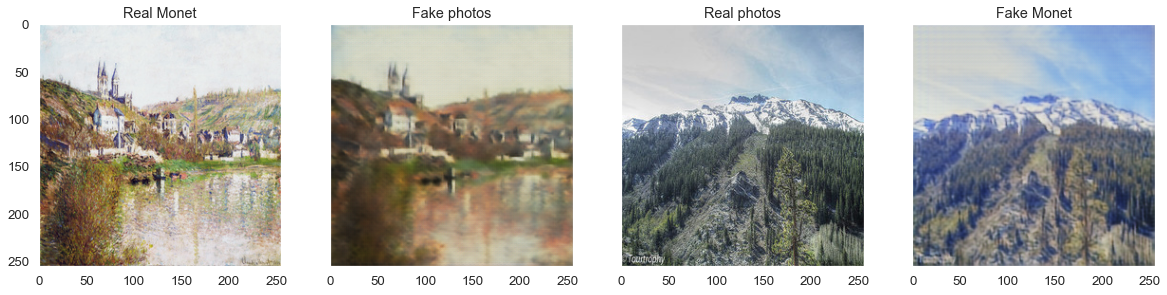

In [24]:
dataloader_test = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False)
fake_images_A = []
fake_images_B = []
with torch.no_grad():
    Gen_A2B.eval()
    Gen_B2A.eval()

    for i, data in enumerate(dataloader_test):
        # get batch size data
        real_images_A = data["A"].to(device)
        real_images_B = data["B"].to(device)

        # Generate output
        fake_image_A = 1 * (Gen_B2A(real_images_B).data)
        fake_image_B = 1 * (Gen_A2B(real_images_A).data)

        fig, ax = plt.subplots(nrows=1, ncols=4,figsize=(20, 5), sharey=True, sharex=True)
        fig_x = ax.flatten()
        imshow(fake_image_B.data.cpu()[0],'Fake photos', plt_ax=fig_x[1])
        imshow(real_images_A.cpu()[0], 'Real Monet', plt_ax=fig_x[0])
        imshow(fake_image_A.data.cpu()[0],'Fake Monet', plt_ax=fig_x[3])
        imshow(real_images_B.cpu()[0],'Real photos', plt_ax=fig_x[2])

It cannot be said that the result is perfect, but it should be noted that the network does not do a bad job of transferring Monet's style to real photos, while maintaining sufficient clarity of photos (it copes especially well with photographs of water). However, there are obvious problems with the transformation from Monet paintings to real photographs. These problems can be attributed to the small batch size for training (only one image fit on the video card), the size of the training dataset and, possibly, the number of epochs (in some articles exploring CycleGANs, they train on 200 epochs, while even 100 epochs took more than 24 hours)